### 3.3.4. DISCRIMINATION POWER OF CONCEPTS

In [8]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path as osp
import matplotlib.pyplot as plt

from typing import Dict, List
from exp_utils import load_interactions, get_significant_threshold, judge_pattern_type_single_sample, \
    filter_raw_interaction_dict, filter_raw_interaction_dict_tictactoe

import sys
sys.path.append("../src")
from datasets import TabularDataset

folders that stores the computed interaction

In [9]:
def get_folder(dataset, arch):
    return {
        "wifi | MLP-5":
            "../saved-interactions/dataset=wifi_balance_model=mlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "wifi | ResMLP-5":
            "../saved-interactions/dataset=wifi_balance_model=resmlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "tictactoe | MLP-5":
            "../saved-interactions/dataset=tictactoe_balance_model=mlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "tictactoe | ResMLP-5":
            "../saved-interactions/dataset=tictactoe_balance_model=resmlp5_epoch=1000_bs=128_lr=0.1_logspace=1_seed=0/dim=gt-log-odds_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | AlexNet":
            "../saved-interactions/dataset=celeba_eyeglasses_model=alexnet_epoch=20_bs=128_lr=0.01_logspace=1_seed=1/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | ResNet-18":
            "../saved-interactions/dataset=celeba_eyeglasses_model=resnet18_epoch=20_bs=128_lr=0.01_logspace=1_seed=1/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "celeba_eyeglasses | ResNet-34":
            "../saved-interactions/dataset=celeba_eyeglasses_model=resnet34_epoch=20_bs=128_lr=0.01_logspace=1_seed=1/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | LeNet":
            "../saved-interactions/dataset=simpleisthree_model=lenet_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-20":
            "../saved-interactions/dataset=simpleisthree_model=resnet20_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-32":
            "../saved-interactions/dataset=simpleisthree_model=resnet32_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | ResNet-44":
            "../saved-interactions/dataset=simpleisthree_model=resnet44_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | VGG-13":
            "../saved-interactions/dataset=simpleisthree_model=vgg13_bn_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "simpleisthree | VGG-16":
            "../saved-interactions/dataset=simpleisthree_model=vgg16_bn_epoch=50_bs=128_lr=0.01_logspace=1_seed=0/dim=0-v0_input=integrated_bg_baseline=zero_loss=l1_qthres=0.04_qstd=vN-v0_lr=1e-05_niter=10000",
        "shapenet | PointNet":
            "../saved-interactions/dataset=shapenet_model=pointnet_epoch=200_bs=32_lr=0.01_logspace=1_seed=0/dim=gt-log-odds-v0_baseline=center_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
        "shapenet | PointNet++":
            "../saved-interactions/dataset=shapenet_model=pointnet2_epoch=200_bs=32_lr=0.01_logspace=1_seed=0/dim=gt-log-odds-v0_baseline=center_loss=l1_qthres=0.04_qstd=vN-v0_lr=0.0001_niter=10000",
    }[f"{dataset} | {arch}"]

Let $\Omega_{\boldsymbol{x}_i}$ denote a set of salient concepts extracted from the sample $\boldsymbol{x}_i$.
Then, $m^+_S\triangleq \sum_{i}\mathbb{1}_{S\in\Omega_{\boldsymbol{x}_i}} \cdot \mathbb{1}_{I(S|\boldsymbol{x}_i)>0}$ denote the number of samples where the concept $S$ makes a salient and positive effect on the classification score.
 Similarly, we can define $m^-_S\triangleq \sum_{i}\mathbb{1}_{S\in\Omega_{\boldsymbol{x}_i}} \cdot \mathbb{1}_{I(S|\boldsymbol{x}_i)<0}$ to denote the number of samples where the concept $S$ makes a salient and negative effect on the classification score.
In this way, the discrimination power of a salient concept $S$ can be measured as $\beta(S)=\max(m^+_S, m^-_S)/(m^+_S + m^-_S)$.

In [10]:
def calculate_discrimination_power(interaction_dict, act_rate_splits, significant_ratio):
    mat_pattern_type = []
    for sample_name in interaction_dict.keys():
        I_and_or = torch.cat(interaction_dict[sample_name])
        threshold = get_significant_threshold(I_and_or, significant_ratio=significant_ratio)
        pattern_type = judge_pattern_type_single_sample(I_and_or, threshold)
        mat_pattern_type.append(pattern_type)

    mat_pattern_type = torch.stack(mat_pattern_type)
    n_sample, n_pattern = mat_pattern_type.shape

    vec_act_rate = torch.mean(torch.abs(mat_pattern_type).float(), dim=0)  # [n_pattern,]
    vec_n_pos = torch.sum((mat_pattern_type == 1).float(), dim=0)
    vec_n_neg = torch.sum((mat_pattern_type == -1).float(), dim=0)
    vec_n_salient = torch.sum(torch.abs(mat_pattern_type).float(), dim=0)
    vec_purity = torch.div(torch.maximum(vec_n_pos, vec_n_neg), vec_n_salient + 1e-7)
    overall_purity = torch.dot(vec_act_rate, vec_purity) / vec_act_rate.sum()  # avg_dp
    overall_purity = overall_purity.item()

    purity_in_intervals = []  # dp_in_intervals
    for lb, ub in zip(act_rate_splits[:-1], act_rate_splits[1:]):
        indices = torch.logical_and(vec_act_rate > lb, vec_act_rate <= ub)
        purity_in_intervals.append(vec_purity[indices].numpy().mean())

    return purity_in_intervals, overall_purity

plot

In [11]:
def ax_plot_discrimination_power_intervals(
        ax: plt.Axes,
        plot_data: Dict,
        act_rate_splits: List,
        title: str,
):

    X = (np.array(act_rate_splits)[:-1] + np.array(act_rate_splits)[1:]) / 2
    for i, (label, (dp_in_intervals, avg_dp)) in enumerate(plot_data.items()):
        ax.plot(X, dp_in_intervals, marker=".", label=label)
    ax.set_title(title, style='italic')
    ax.set_ylabel(r"discrimination power $\beta$")
    ax.set_xlabel(r"frequency $\alpha$")
    ax.set_ylim([0.48, 1.02])
    ax.set_xticks(act_rate_splits, act_rate_splits)
    ax.legend(loc='lower right')

experiment config

In [12]:
significant_ratio = 0.05
act_rate_splits = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

configs = [
    dict(
        dataset="tictactoe",
        arch_list=["MLP-5", "ResMLP-5"],
        selected_classes=[2],  # selected patterns
        title = "tic-tac-toe",
    ),
    dict(
        dataset = "wifi",
        arch_list = ["MLP-5", "ResMLP-5"],
        selected_classes = ["class_3"],
        title="wifi",
    ),
    dict(
        dataset = "simpleisthree",
        arch_list = ["LeNet", "ResNet-20", "ResNet-32", "ResNet-44", "VGG-13", "VGG-16"],
        selected_classes = ["class_1"],
        title="MNIST-3",
    ),
    dict(
        dataset = "celeba_eyeglasses",
        arch_list = ["AlexNet", "ResNet-18", "ResNet-34"],
        selected_classes = ["class_1"],
        title="CelebA-eyeglasses",
    ),
    dict(
        dataset = "shapenet",
        arch_list = ["PointNet", "PointNet++"],
        selected_classes = ["motorbike"],
        title="ShapeNet",
    )
]

loading: 100%|██████████████| 50/50 [00:00<00:00, 865.22it/s, --> LOADING sample_00999 FROM class_1]
loading: 100%|█| 99/99 [00:00<00:00, 828.31it/s, --> LOADING sample_fad668ac64ccea1ab37378f3c85478b4
loading: 100%|█| 99/99 [00:00<00:00, 845.61it/s, --> LOADING sample_fad668ac64ccea1ab37378f3c85478b4


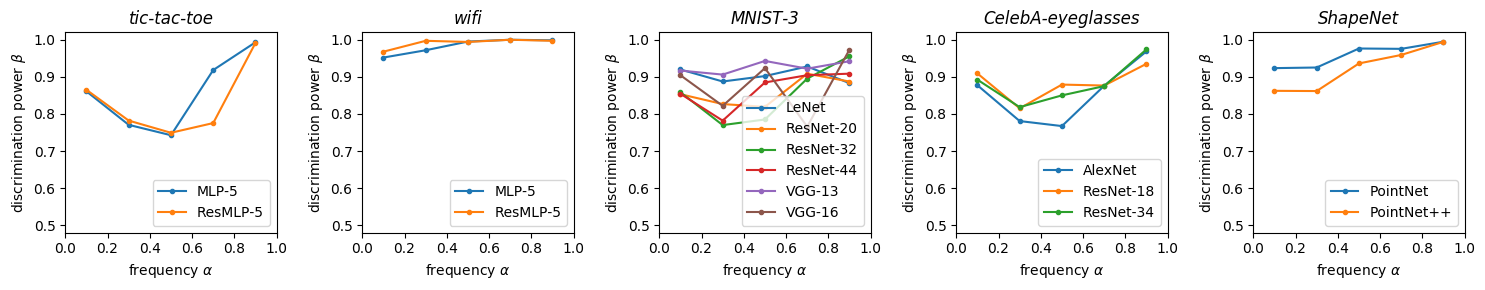

In [13]:
fig, axes = plt.subplots(1, len(configs), figsize=(3 * len(configs), 3))
for i, config in enumerate(configs):
    dataset = config["dataset"]
    arch_list = config["arch_list"]
    selected_classes = config["selected_classes"]
    title = config["title"]

    if dataset == "tictactoe":
        data = TabularDataset('/data2/lmj/data/tabular', dataset)
        X_train, y_train, X_test, y_test = data.get_data()
        X_all = torch.cat([X_train, X_test])
        y_all = torch.cat([y_train, y_test])
    else:
        X_all = None

    plot_dict = {}
    for arch in arch_list:
        result_folder = get_folder(dataset, arch)
        interaction_dict = load_interactions(dataset, result_folder)
        if dataset == "tictactoe":
            interaction_dict = filter_raw_interaction_dict_tictactoe(interaction_dict, X_all, selected_classes)
        else:
            interaction_dict = filter_raw_interaction_dict(interaction_dict, selected_classes)
        disc_power = calculate_discrimination_power(interaction_dict, act_rate_splits, significant_ratio)
        plot_dict[arch] = disc_power

    ax_plot_discrimination_power_intervals(
        ax=axes[i],
        plot_data=plot_dict,
        act_rate_splits=act_rate_splits,
        title=title,
    )

plt.tight_layout()
plt.show()